In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
from itertools import product
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, recall_score
import pickle
# Set random seeds for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)

# Load dataset
df = pd.read_excel("data ta bener.xlsx")

# Separate features and target
X = df.drop(['Y', 'Perusahaan', 'Tahun'], axis=1)
y = df['Y']

# Split data into training and testing sets BEFORE applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Apply SMOTE on the training data
smote = SMOTE(random_state=42, k_neighbors=3)  # Set k_neighbors to be less than the smallest class
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Standardize the data
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)  # Fit on training data and transform
X_test = scaler.transform(X_test)  # Transform test data based on training data fit

# After finding the best model, save it using pickle
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
Y_train_tensor = torch.tensor(y_train_resampled.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)


# Define hyperparameters to test
learning_rates = [0.0001, 0.00001]
hidden_layer_combinations = [(8, 5), (5, 5), [8]]
epochs_list = [300, 500, 800]

# Initialize variables to store the best metrics and hyperparameters
best_metrics = {
    'test_accuracy': 0,
    'train_accuracy': 0,
    'sensitivity': 0,
    'specificity': 0,
    'f1_score': 0,
    'hyperparameters': None
}

# Store results for each hyperparameter combination
results = []

# Perform grid search over hyperparameters
for lr, hidden_layers, num_epochs in product(learning_rates, hidden_layer_combinations, epochs_list):
    print(f"Testing hyperparameters: Learning Rate = {lr}, Hidden Layers = {hidden_layers}, Epochs = {num_epochs}")

    # Build the model architecture
    layers = []
    input_size = X_train_resampled.shape[1]
    for hidden_size in hidden_layers:
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.ReLU())
        input_size = hidden_size
    layers.append(nn.Linear(input_size, 1))
    layers.append(nn.Sigmoid())
    model = nn.Sequential(*layers)

    # Define the loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, Y_train_tensor)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Log the training accuracy every 100 epochs
        if (epoch + 1) % 100 == 0:
            predictions = (outputs > 0.5).float()
            train_accuracy = (predictions == Y_train_tensor).float().mean().item()
            print(f"Epoch: {epoch+1} | Loss: {loss.item():.4f} | Train Accuracy: {train_accuracy:.4f}")

    # Evaluation phase
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        test_predictions = (test_outputs > 0.5).float()
        test_accuracy = (test_predictions == Y_test_tensor).float().mean().item()

        # Calculate confusion matrix and metrics
        test_predictions_np = test_predictions.cpu().numpy()  # Move predictions to CPU
        Y_test_np = Y_test_tensor.cpu().numpy()  # Move true values to CPU

        tn, fp, fn, tp = confusion_matrix(Y_test_np, test_predictions_np).ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
        f1 = f1_score(Y_test_np, test_predictions_np)

        print(f"Test Accuracy: {test_accuracy:.4f}")
        print(f"Sensitivity: {sensitivity:.4f} | Specificity: {specificity:.4f} | F1-Score: {f1:.4f}")

        # Save the current results
        current_results = {
            'learning_rate': lr,
            'hidden_neuron': hidden_layers,
            'num_epochs': num_epochs,
            'train_accuracy': train_accuracy,
            'test_accuracy': test_accuracy,
            'sensitivity': sensitivity,
            'specificity': specificity,
            'f1_score': f1
        }
        results.append(current_results)

        # Update best metrics if the current model is better
        if test_accuracy > best_metrics['test_accuracy']:
            best_metrics = {
                'test_accuracy': test_accuracy,
                'train_accuracy': train_accuracy,
                'sensitivity': sensitivity,
                'specificity': specificity,
                'f1_score': f1,
                'hyperparameters': {
                    'learning_rate': lr,
                    'hidden_layers': hidden_layers,
                    'num_epochs': num_epochs
                }
            }

# Convert results to a DataFrame for easy viewing
results_df = pd.DataFrame(results)

# Final model training using the best hyperparameters
# Build the final model architecture
layers = []
input_size = X_train_resampled.shape[1]
for hidden_size in best_metrics['hyperparameters']['hidden_layers']:
    layers.append(nn.Linear(input_size, hidden_size))
    layers.append(nn.ReLU())
    input_size = hidden_size
layers.append(nn.Linear(input_size, 1))
layers.append(nn.Sigmoid())
final_model = nn.Sequential(*layers)

# Define the loss function and optimizer
final_criterion = nn.BCELoss()
final_optimizer = optim.Adam(final_model.parameters(), lr=best_metrics['hyperparameters']['learning_rate'])

# Train the final model
final_model.train()
for epoch in range(best_metrics['hyperparameters']['num_epochs']):
    final_outputs = final_model(X_train_tensor)
    final_loss = final_criterion(final_outputs, Y_train_tensor)

    final_optimizer.zero_grad()
    final_loss.backward()
    final_optimizer.step()

    if (epoch + 1) % 100 == 0:
        print(f"Final Model - Epoch: {epoch + 1} | Loss: {final_loss.item():.4f}")

# Final predictions
with torch.no_grad():
    y_final_train_pred = (final_model(X_train_tensor) > 0.5).float().cpu().numpy()
    y_final_test_pred = (final_model(X_test_tensor) > 0.5).float().cpu().numpy()

# Evaluate final accuracy
final_train_accuracy = accuracy_score(y_train_resampled, y_final_train_pred)
final_test_accuracy = accuracy_score(y_test, y_final_test_pred)
final_sensitivity = recall_score(y_test, y_final_test_pred)
final_specificity = recall_score(y_test, y_final_test_pred, pos_label=0)
final_f1 = f1_score(y_test, y_final_test_pred)

# Display the best results
print("\nBest Metrics:")
print(f"Test Accuracy: {best_metrics['test_accuracy']:.4f}")
print(f"Train Accuracy: {best_metrics['train_accuracy']:.4f}")
print(f"Sensitivity: {best_metrics['sensitivity']:.4f}")
print(f"Specificity: {best_metrics['specificity']:.4f}")
print(f"F1-Score: {best_metrics['f1_score']:.4f}")



Testing hyperparameters: Learning Rate = 0.0001, Hidden Layers = (8, 5), Epochs = 300
Epoch: 100 | Loss: 0.6945 | Train Accuracy: 0.5000
Epoch: 200 | Loss: 0.6879 | Train Accuracy: 0.5000
Epoch: 300 | Loss: 0.6807 | Train Accuracy: 0.5000
Test Accuracy: 0.0870
Sensitivity: 1.0000 | Specificity: 0.0000 | F1-Score: 0.1600
Testing hyperparameters: Learning Rate = 0.0001, Hidden Layers = (8, 5), Epochs = 500
Epoch: 100 | Loss: 0.7225 | Train Accuracy: 0.5000
Epoch: 200 | Loss: 0.7173 | Train Accuracy: 0.5000
Epoch: 300 | Loss: 0.7120 | Train Accuracy: 0.5000
Epoch: 400 | Loss: 0.7066 | Train Accuracy: 0.5000
Epoch: 500 | Loss: 0.7004 | Train Accuracy: 0.5000
Test Accuracy: 0.9130
Sensitivity: 0.0000 | Specificity: 1.0000 | F1-Score: 0.0000
Testing hyperparameters: Learning Rate = 0.0001, Hidden Layers = (8, 5), Epochs = 800
Epoch: 100 | Loss: 0.6873 | Train Accuracy: 0.5843
Epoch: 200 | Loss: 0.6817 | Train Accuracy: 0.6265
Epoch: 300 | Loss: 0.6731 | Train Accuracy: 0.6566
Epoch: 400 | Lo

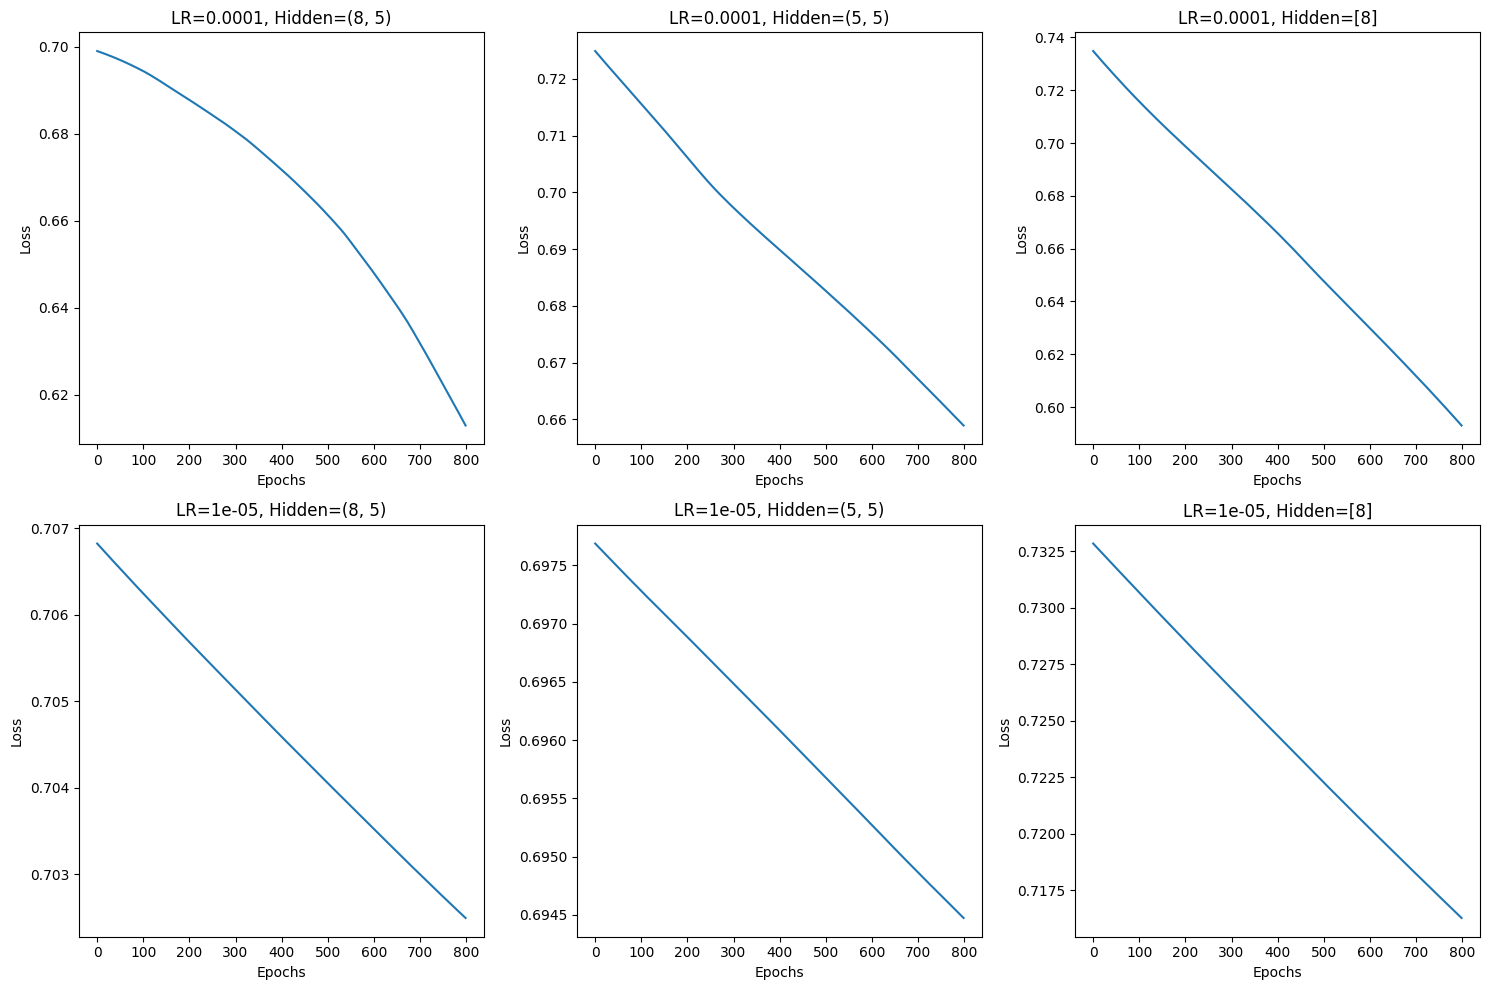

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
from itertools import product
import numpy as np
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)

# Load dataset
df = pd.read_excel("data ta bener.xlsx")

# Separate features and target
X = df.drop(['Y', 'Perusahaan', 'Tahun'], axis=1)
y = df['Y']

# Split data into training and testing sets BEFORE applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Apply SMOTE on the training data
smote = SMOTE(random_state=42, k_neighbors=3)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Standardize the data
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_resampled, dtype=torch.float32)
Y_train_tensor = torch.tensor(y_train_resampled.values, dtype=torch.float32).unsqueeze(1)

# Define hyperparameters to test
learning_rates = [0.0001, 0.00001]
hidden_layer_combinations = [(8, 5), (5, 5), [8]]
max_epochs = 800  # Use only 800 epochs for each configuration

# Prepare a 2x3 grid for subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Perform grid search over learning rate and hidden layer combinations only
for idx, (lr, hidden_layers) in enumerate(product(learning_rates, hidden_layer_combinations)):
    # Build the model architecture
    layers = []
    input_size = X_train_resampled.shape[1]
    for hidden_size in hidden_layers:
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.ReLU())
        input_size = hidden_size
    layers.append(nn.Linear(input_size, 1))
    layers.append(nn.Sigmoid())
    model = nn.Sequential(*layers)

    # Define the loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Track loss values for plotting
    loss_values = []

    # Training loop for the maximum number of epochs (800)
    for epoch in range(max_epochs):
        model.train()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, Y_train_tensor)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Store the loss value
        loss_values.append(loss.item())

    # Plot the loss values on the subplot for this configuration
    axes[idx].plot(range(max_epochs), loss_values)
    axes[idx].set_title(f"LR={lr}, Hidden={hidden_layers}")
    axes[idx].set_xlabel('Epochs')
    axes[idx].set_ylabel('Loss')

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
results_df
# Atau simpan ke file Excel
results_df.to_excel('results_df.xlsx', index=False)
print(results_df)

    learning_rate hidden_neuron  num_epochs  train_accuracy  test_accuracy  \
0         0.00010        [8, 5]         300        0.500000       0.086957   
1         0.00010        [8, 5]         500        0.500000       0.913043   
2         0.00010        [8, 5]         800        0.879518       0.956522   
3         0.00010        [5, 5]         300        0.500000       0.913043   
4         0.00010        [5, 5]         500        0.554217       0.217391   
5         0.00010        [5, 5]         800        0.620482       0.956522   
6         0.00010           [8]         300        0.524096       0.913043   
7         0.00010           [8]         500        0.849398       0.869565   
8         0.00010           [8]         800        0.885542       0.956522   
9         0.00001        [8, 5]         300        0.463855       0.869565   
10        0.00001        [8, 5]         500        0.620482       0.391304   
11        0.00001        [8, 5]         800        0.500000     

In [ ]:
torch.save(final_model, 'final_model.pth')

<ipython-input-16-b0e42d4a6d5a>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("final_model.pth")


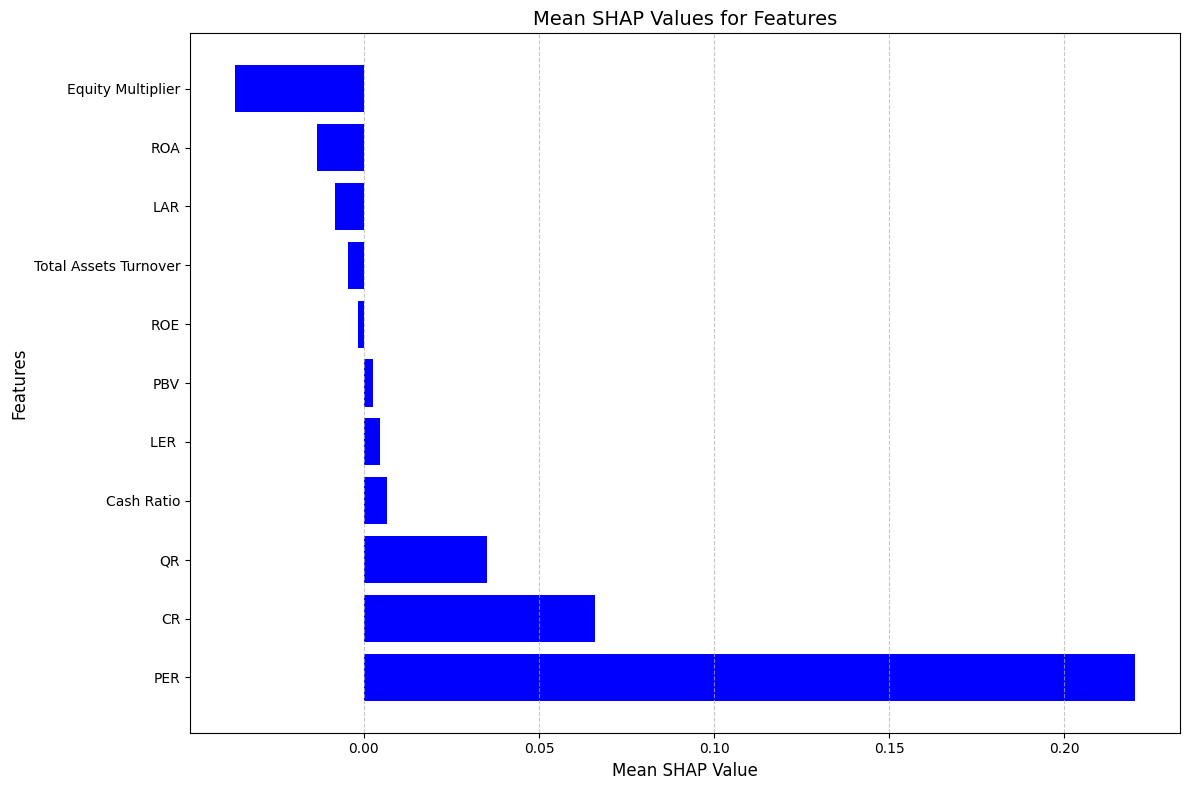

In [ ]:
import torch
import shap
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load the model
model = torch.load("final_model.pth")

# Convert X_train and X_test to NumPy arrays if they are DataFrames
X_train_np = X_train.values if isinstance(X_train, pd.DataFrame) else X_train
X_test_np = X_test.values if isinstance(X_test, pd.DataFrame) else X_test

# Ensure X_train_np and X_test_np are 2D arrays before conversion
if len(X_train_np.shape) == 1:
    X_train_np = X_train_np.reshape(-1, 1)
if len(X_test_np.shape) == 1:
    X_test_np = X_test_np.reshape(-1, 1)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_np, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_np, dtype=torch.float32)

# Initialize the GradientExplainer with the model and training data tensor
explainer = shap.GradientExplainer(model, X_train_tensor)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test_tensor)

# Ensure mean_shap_values is a 1D array by calculating mean along the correct axis
mean_shap_values = np.mean(shap_values, axis=0).flatten()

# Create a dictionary with feature names and their mean SHAP values
shap_dict = dict(zip(X_train.columns, mean_shap_values))

# Sort SHAP values for plotting
sorted_shap_dict = dict(sorted(shap_dict.items(), key=lambda item: item[1], reverse=True))

# Plotting the horizontal bar chart
plt.figure(figsize=(12, 8))  # Set figure size
plt.barh(list(sorted_shap_dict.keys()), list(sorted_shap_dict.values()), color='blue')

# Labeling axes and title
plt.ylabel('Features', fontsize=12)
plt.xlabel('Mean SHAP Value', fontsize=12)
plt.title('Mean SHAP Values for Features', fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.7)  # Optional: Add grid lines for readability

# Show the plot
plt.tight_layout()
plt.show()


TANPA SMOTE

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
from itertools import product
import numpy as np
from sklearn.metrics import confusion_matrix, f1_score

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Load dataset
df = pd.read_excel("data ta bener.xlsx")

# Separate features and target
X = df.drop(['Y', 'Perusahaan', 'Tahun'], axis=1)
y = df['Y']

# Split data into training and testing sets BEFORE applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.2, random_state=42)

scaler = StandardScaler() #Mengubah data menjadi bentuk yang distandarkan (mean=0, variance=1).
X_train = scaler.fit_transform(X_train) #Melakukan fitting pada data pelatihan dan kemudian mentransformasi.
X_test = scaler.transform(X_test) #Mentransformasi data pengujian berdasarkan fitting dari data pelatihan

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Define hyperparameters to test
learning_rates = [0.0001,0.00001]
hidden_sizes = [[8,5],[5,5],[8]]
epochs_list = [300,500,800]

# Initialize variables to store the best metrics and hyperparameters
best_metrics = {
    'test_accuracy': 0,
    'train_accuracy': 0,
    'sensitivity': 0,
    'specificity': 0,
    'f1_score': 0,
    'hyperparameters': None
}

# Store results for each hyperparameter combination
results = []

# Perform grid search over hyperparameters
for lr, hidden_sizes, num_epochs in product(learning_rates, hidden_sizes, epochs_list):
    print(f"Testing hyperparameters: Learning Rate = {lr}, Hidden Layers = {hidden_sizes}, Epochs = {num_epochs}")

    # Build the model architecture
    layers = []
    input_size = X_train.shape[1]
    for hidden_size in hidden_sizes:
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.ReLU())
        input_size = hidden_size
    layers.append(nn.Linear(input_size, 1))
    layers.append(nn.Sigmoid())
    model = nn.Sequential(*layers)

    # Define the loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, Y_train_tensor)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Every 100 epochs, log the training accuracy
        if (epoch + 1) % 100 == 0:
            predictions = (outputs > 0.5).float()
            train_accuracy = (predictions == Y_train_tensor).float().mean().item()
            print(f"Epoch: {epoch+1} | Loss: {loss.item():.4f} | Train Accuracy: {train_accuracy:.4f}")

    # Evaluation phase
    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test_tensor)
        test_predictions = (test_outputs > 0.5).float()
        test_accuracy = (test_predictions == Y_test_tensor).float().mean().item()

        # Calculate confusion matrix and metrics
        test_predictions_np = test_predictions.numpy()
        Y_test_np = Y_test_tensor.numpy()

        tn, fp, fn, tp = confusion_matrix(Y_test_np, test_predictions_np).ravel()
        sensitivity = tp / (tp + fn) if (tp + fn) != 0 else 0
        specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
        f1 = f1_score(Y_test_np, test_predictions_np)

        print(f"Test Accuracy: {test_accuracy:.4f}")
        print(f"Sensitivity: {sensitivity:.4f} | Specificity: {specificity:.4f} | F1-Score: {f1:.4f}")

        # Save the current results
        current_results = {
            'learning_rate': lr,
            'hidden_neuron': hidden_sizes,
            'num_epochs': num_epochs,
            'train_accuracy': train_accuracy,
            'test_accuracy': test_accuracy,
            'sensitivity': sensitivity,
            'specificity': specificity,
            'f1_score': f1
        }
        results.append(current_results)

        # Update best metrics if the current model is better
        if test_accuracy > best_metrics['test_accuracy']:
            best_metrics = {
                'test_accuracy': test_accuracy,
                'train_accuracy': train_accuracy,
                'sensitivity': sensitivity,
                'specificity': specificity,
                'f1_score': f1,
                'hyperparameters': {
                    'learning_rate': lr,
                    'hidden_layers': hidden_sizes,
                    'num_epochs': num_epochs
                }
            }

# Convert results to a DataFrame for easy viewing
results_df = pd.DataFrame(results)

# Display the best results
print("\nBest Metrics:")
print(f"Test Accuracy: {best_metrics['test_accuracy']:.4f}")
print(f"Train Accuracy: {best_metrics['train_accuracy']:.4f}")
print(f"Sensitivity: {best_metrics['sensitivity']:.4f}")
print(f"Specificity: {best_metrics['specificity']:.4f}")
print(f"F1-Score: {best_metrics['f1_score']:.4f}")


Testing hyperparameters: Learning Rate = 0.0001, Hidden Layers = [8, 5], Epochs = 300
Epoch: 100 | Loss: 0.7927 | Train Accuracy: 0.0879
Epoch: 200 | Loss: 0.7802 | Train Accuracy: 0.0879
Epoch: 300 | Loss: 0.7656 | Train Accuracy: 0.0879
Test Accuracy: 0.0870
Sensitivity: 1.0000 | Specificity: 0.0000 | F1-Score: 0.1600
Testing hyperparameters: Learning Rate = 0.0001, Hidden Layers = [8, 5], Epochs = 500
Epoch: 100 | Loss: 0.5068 | Train Accuracy: 0.9121
Epoch: 200 | Loss: 0.4987 | Train Accuracy: 0.9121
Epoch: 300 | Loss: 0.4885 | Train Accuracy: 0.9121
Epoch: 400 | Loss: 0.4769 | Train Accuracy: 0.9121
Epoch: 500 | Loss: 0.4642 | Train Accuracy: 0.9121
Test Accuracy: 0.9130
Sensitivity: 0.0000 | Specificity: 1.0000 | F1-Score: 0.0000
Testing hyperparameters: Learning Rate = 0.0001, Hidden Layers = [8, 5], Epochs = 800
Epoch: 100 | Loss: 0.6344 | Train Accuracy: 0.9341
Epoch: 200 | Loss: 0.6223 | Train Accuracy: 0.9231
Epoch: 300 | Loss: 0.6083 | Train Accuracy: 0.9231
Epoch: 400 | Lo

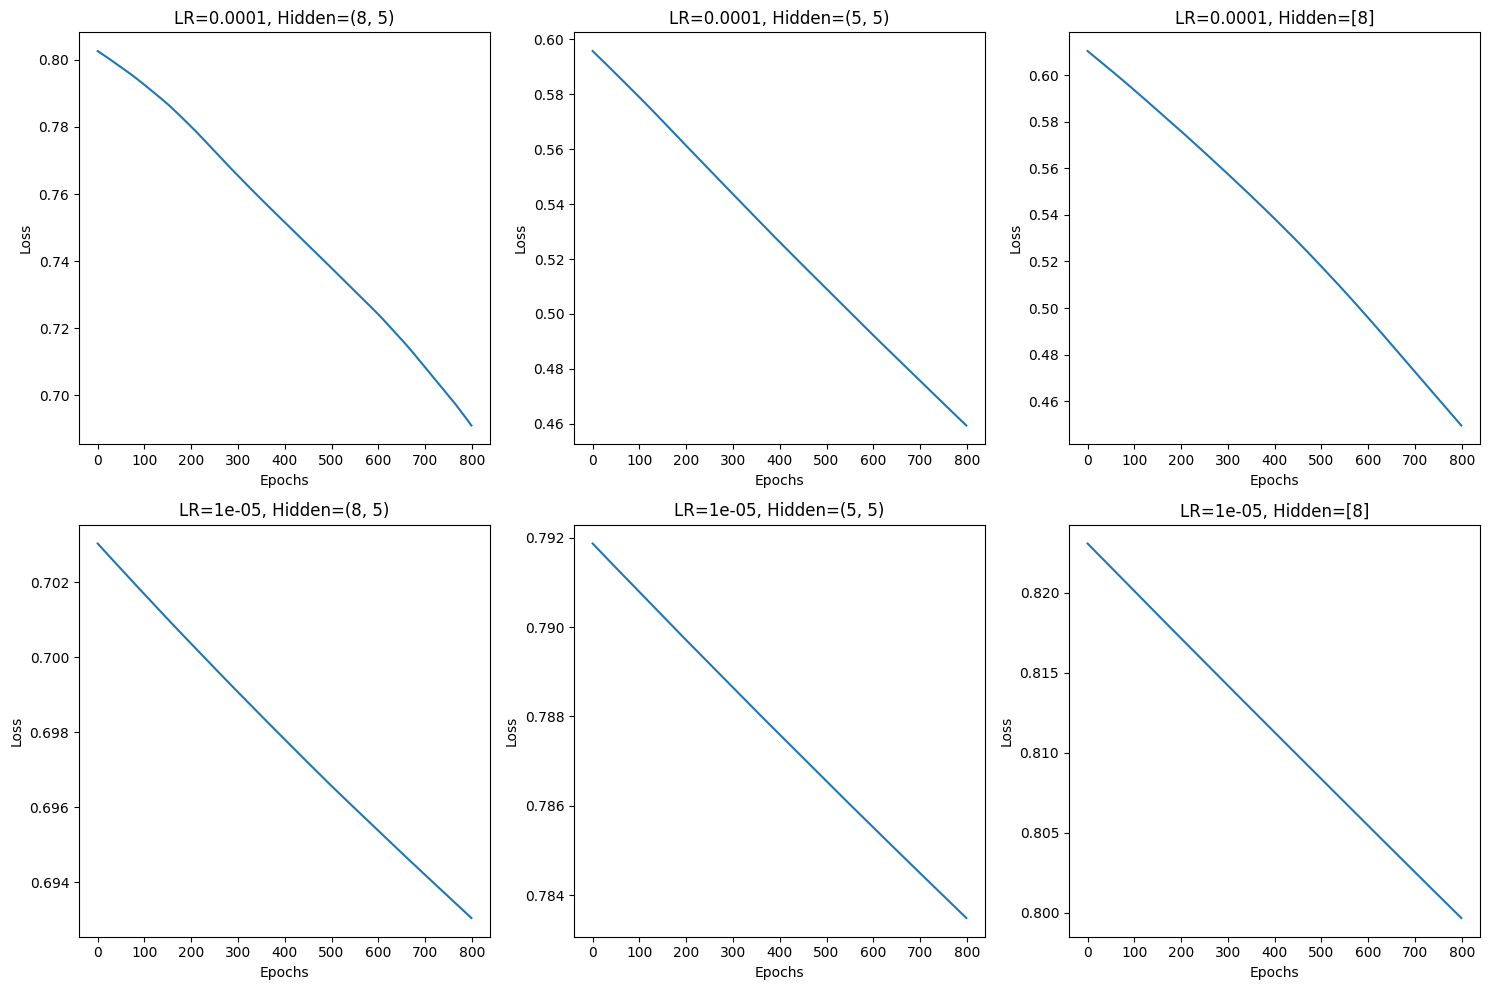

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
from itertools import product
import numpy as np
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)

# Load dataset
df = pd.read_excel("data ta bener.xlsx")

# Separate features and target
X = df.drop(['Y', 'Perusahaan', 'Tahun'], axis=1)
y = df['Y']

# Split data into training and testing sets BEFORE applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.2, random_state=42)

scaler = StandardScaler() #Mengubah data menjadi bentuk yang distandarkan (mean=0, variance=1).
X_train = scaler.fit_transform(X_train) #Melakukan fitting pada data pelatihan dan kemudian mentransformasi.
X_test = scaler.transform(X_test) #Mentransformasi data pengujian berdasarkan fitting dari data pelatihan

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
Y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

# Define hyperparameters to test
learning_rates = [0.0001, 0.00001]
hidden_layer_combinations = [(8, 5), (5, 5), [8]]
max_epochs = 800  # Use only 800 epochs for each configuration

# Prepare a 2x3 grid for subplots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

# Perform grid search over learning rate and hidden layer combinations only
for idx, (lr, hidden_layers) in enumerate(product(learning_rates, hidden_layer_combinations)):
    # Build the model architecture
    layers = []
    input_size = X_train_resampled.shape[1]
    for hidden_size in hidden_layers:
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.ReLU())
        input_size = hidden_size
    layers.append(nn.Linear(input_size, 1))
    layers.append(nn.Sigmoid())
    model = nn.Sequential(*layers)

    # Define the loss function and optimizer
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Track loss values for plotting
    loss_values = []

    # Training loop for the maximum number of epochs (800)
    for epoch in range(max_epochs):
        model.train()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, Y_train_tensor)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Store the loss value
        loss_values.append(loss.item())

    # Plot the loss values on the subplot for this configuration
    axes[idx].plot(range(max_epochs), loss_values)
    axes[idx].set_title(f"LR={lr}, Hidden={hidden_layers}")
    axes[idx].set_xlabel('Epochs')
    axes[idx].set_ylabel('Loss')

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
results_df
# Atau simpan ke file Excel
results_df.to_excel('results_df_tanpas smote.xlsx', index=False)
print(results_df)

    learning_rate hidden_neuron  num_epochs  train_accuracy  test_accuracy  \
0         0.00010        [8, 5]         300        0.087912       0.086957   
1         0.00010        [8, 5]         500        0.912088       0.913043   
2         0.00010        [8, 5]         800        0.934066       0.956522   
3         0.00010        [5, 5]         300        0.912088       0.913043   
4         0.00010        [5, 5]         500        0.109890       0.086957   
5         0.00010        [5, 5]         800        0.923077       0.913043   
6         0.00010           [8]         300        0.912088       0.913043   
7         0.00010           [8]         500        0.967033       0.956522   
8         0.00010           [8]         800        0.956044       0.869565   
9         0.00001        [8, 5]         300        0.824176       0.913043   
10        0.00001        [8, 5]         500        0.461538       0.391304   
11        0.00001        [8, 5]         800        0.912088     

In [ ]:
import graphviz

# Membuat objek Digraph
dot = graphviz.Digraph(comment='Neural Network Architecture', engine='dot')
dot.attr(rankdir='LR')  # Left to Right layout
dot.attr(splines='polyline')  # Menggunakan garis lurus untuk koneksi

# Mengatur style untuk graph
dot.attr('node', shape='none')  # Default shape untuk node
dot.attr(nodesep='0.3')  # Jarak antar node dalam satu layer
dot.attr(ranksep='3')    # Jarak antar layer

# Input Layer
with dot.subgraph(name='cluster_0') as c:
    c.attr(label='Input Layer')
    c.attr(style='white')
    c.attr(rank='same')

    # Membuat input nodes dengan posisi yang rapi
    inputs = ['ROA', 'DAR', 'CR', 'QR', 'Cash Ratio',
              'DER', 'Equity Multiplier', 'ROE',
              'Total Assets Turnover', 'PER', 'PBV']

    for i, input_name in enumerate(inputs):
        c.node(f'input_{i}', input_name,
               fontsize='14',
               fontname='Arial')

# Hidden Layer 1
with dot.subgraph(name='cluster_1') as c:
    c.attr(label='Hidden Layer 1')
    c.attr(style='white')
    c.attr(rank='same')

    # Membuat 8 nodes untuk hidden layer pertama
    for i in range(8):
        c.node(f'hidden1_{i}', f'H1_{i+1}',
               shape='circle',
               style='filled',
               fillcolor='lightblue',
               width='0.8',
               height='0.8',
               fixedsize='true',
               fontsize='14',
               fontname='Arial')

# Hidden Layer 2
with dot.subgraph(name='cluster_2') as c:
    c.attr(label='Hidden Layer 2')
    c.attr(style='white')
    c.attr(rank='same')

    # Membuat 5 nodes untuk hidden layer kedua
    for i in range(5):
        c.node(f'hidden2_{i}', f'H2_{i+1}',
               shape='circle',
               style='filled',
               fillcolor='lightcoral',
               width='0.8',
               height='0.8',
               fixedsize='true',
               fontsize='14',
               fontname='Arial')

# Output Layer
with dot.subgraph(name='cluster_3') as c:
    c.attr(label='Output Layer')
    c.attr(style='white')
    c.attr(rank='same')
    c.node('output', 'Output',
           shape='circle',
           style='filled',
           fillcolor='lightgreen',
           width='0.8',
           height='0.8',
           fixedsize='true',
           fontsize='14',
           fontname='Arial')

# Membuat connections dari input ke hidden layer 1
for i in range(len(inputs)):
    for j in range(8):
        dot.edge(f'input_{i}', f'hidden1_{j}',
                 penwidth='0.6')

# Membuat connections dari hidden layer 1 ke hidden layer 2
for i in range(8):
    for j in range(5):
        dot.edge(f'hidden1_{i}', f'hidden2_{j}',
                 penwidth='0.6')

# Membuat connections dari hidden layer 2 ke output
for i in range(5):
    dot.edge(f'hidden2_{i}', 'output',
             penwidth='0.6')

# Mengatur ukuran gambar
dot.attr(size='14,6')

# Render dan save sebagai JPG
dot.render('neural_network', format='jpg', cleanup=True)


'neural_network.jpg'